___
<h1> Machine Learning </h1>
<h2> Systems Engineering and Computer Technologies / Engenharia de Sistemas e Tecnologias Informáticas
(LESTI)</h2>
<h3> Instituto Superior de Engenharia / Universidade do Algarve </h3>

[LESTI](https://ise.ualg.pt/curso/1941) / [ISE](https://ise.ualg.pt) / [UAlg](https://www.ualg.pt)

Pedro J. S. Cardoso (pcardoso@ualg.pt)

___

# Grid Search

Grid search is a way to find the best parameters for a model. It is a search through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

For example, if our model is a KNN classifier, we might want to find the best value for `n_neighbors` and `metric`. We could do this by defining a grid in the parameter space:
 
- `n_neighbors` = 1, 3, 5, 7, 9, 11, 13, 15
- `metric` = 'euclidean', 'manhattan'

and then evaluate the accuracy of the model for each combination of these parameters.

This would result on 16 different models, and we would select the one with the best accuracy. The models would be trained using the pairs __(`n_neighbors`, `metric`) $\in $ { (1, 'euclidean'), (1, 'manhattan'), (3, 'euclidean'), (3, 'manhattan'), ... , (15, 'euclidean'),  (15, 'manhattan') }.__

## Simple Grid Search

In this section we'll do some simple grid search (by hand)

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pandas as pd
import matplotlib.pyplot as plt

Let us start by doing it without a validation set. We will split the data into training and test sets

In [2]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target, 
                                                    random_state=100)

Find the best parameters according with the training and validation sets

In [3]:
best_score = -1                                     # best score so far

list_of_params = [.001, 0.01, 0.1, 1, 10, 100]      # list of parameters to try out

for gamma in list_of_params:                        # for each gamma in the list
    for C in list_of_params:                        # for each C in the list
        
        svm = SVC(gamma=gamma, C=C) \
            .fit(X_train, y_train)                  # train the model
        
        score = svm.score(X_test, y_test)           # test the model
        
        if score > best_score:                      # update the best, if needed
            best_model = svm
            best_score = score
            best_params = {'C': C, 'gamma': gamma}

print(f'Over the test set, the best params are: {best_params} with a score of: {best_score}')

Over the test set, the best params are: {'C': 1, 'gamma': 0.001} with a score of: 0.9933333333333333


## How should we provide a better estimate of the generalization performance?

We tried many different parameters and selected the one with the best accuracy on the test set, but this accuracy won’t necessarily carry over to new data. Because we used the test data to adjust the parameters, we can no longer use it to assess how good the model is. 

This is the same reason we needed to split the data into training and test sets in the first place; we need an independent dataset to evaluate, one that was not used to create the model.

Let us start by building a training (60%), a testing (20%), and a validation (20%) sets

In [4]:
digits = load_digits()

X_train_validate, X_test, y_train_validate, y_test = train_test_split(digits.data,
                                                    digits.target, 
                                                    test_size=.2,
                                                    random_state=0)

X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate,
                                                    y_train_validate, 
                                                    test_size=.25, # this will give 20% of the original set
                                                    random_state=0)

Do the same grid search...

In [5]:
best_score = 0

list_of_params = [.001, 0.01, 0.1, 1, 10, 100]

for gamma in list_of_params:
    for C in list_of_params:
        svm = SVC(gamma=gamma, C=C).fit(X_train, y_train)
        score = svm.score(X_validate, y_validate)
        
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}
            
print(f'Over the validation set, the best params are: {best_params} with a score of: {best_score}')   

Over the validation set, the best params are: {'C': 10, 'gamma': 0.001} with a score of: 0.9916666666666667


Now we rebuild the model on the combined training and validation set and test it with the test set: How does it behave on the test set?

In [6]:
svm = SVC(**best_params).fit(X_train_validate, y_train_validate)
score = svm.score(X_test, y_test)

print(f'Over the test set the score is: {score}')

Over the test set the score is: 0.9916666666666667


Not bad ehm!?

## Grid Search with Cross-Validation

For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination.

In [7]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target, 
                                                    random_state=100)

In [8]:
best_score = 0

labels=[]
values=[]

list_of_params = [.001, 0.01, 0.1, 1, 10, 100]

for gamma in list_of_params:
    for C in list_of_params:
        svm = SVC(gamma=gamma, C=C)
        score_array = cross_val_score(estimator=svm, 
                                      X=X_train, 
                                      y=y_train, 
                                      cv=10)
        
        mean_score = score_array.mean()
        
        labels.append(f'C={C}/gamma={gamma}')
        values.append(score_array)
        
        if mean_score > best_score:
            best_score = mean_score
            best_score_array = score_array
            best_params = {'C': C, 'gamma': gamma}

        
        
print(f'best param are {best_params} with a mean score {best_score} \n(the scores values where {best_score_array})')

best param are {'C': 1, 'gamma': 0.001} with a mean score 0.9896019900497512 
(the scores values where [0.99259259 0.97777778 1.         0.98518519 1.         0.99259259
 0.98518519 0.99253731 0.99253731 0.97761194])


In [9]:
SVC(**best_params).fit(X_train, y_train).score(X_test, y_test)

0.9933333333333333

The all set of values are

In [10]:
values

[array([0.21481481, 0.20740741, 0.20740741, 0.21481481, 0.21481481,
        0.1037037 , 0.1037037 , 0.10447761, 0.10447761, 0.10447761]),
 array([0.21481481, 0.20740741, 0.20740741, 0.21481481, 0.21481481,
        0.1037037 , 0.1037037 , 0.10447761, 0.10447761, 0.10447761]),
 array([0.94814815, 0.94074074, 0.95555556, 0.97037037, 0.99259259,
        0.97037037, 0.94074074, 0.96268657, 0.97761194, 0.94029851]),
 array([0.99259259, 0.97777778, 1.        , 0.98518519, 1.        ,
        0.99259259, 0.98518519, 0.99253731, 0.99253731, 0.97761194]),
 array([0.99259259, 0.97777778, 1.        , 0.98518519, 0.99259259,
        0.98518519, 0.98518519, 0.99253731, 0.99253731, 0.97761194]),
 array([0.99259259, 0.97777778, 1.        , 0.98518519, 0.99259259,
        0.98518519, 0.98518519, 0.99253731, 0.99253731, 0.97761194]),
 array([0.11851852, 0.11851852, 0.12592593, 0.11851852, 0.12592593,
        0.1037037 , 0.1037037 , 0.10447761, 0.10447761, 0.10447761]),
 array([0.11851852, 0.11851852, 0.

Lets us plot these values... what do you think?

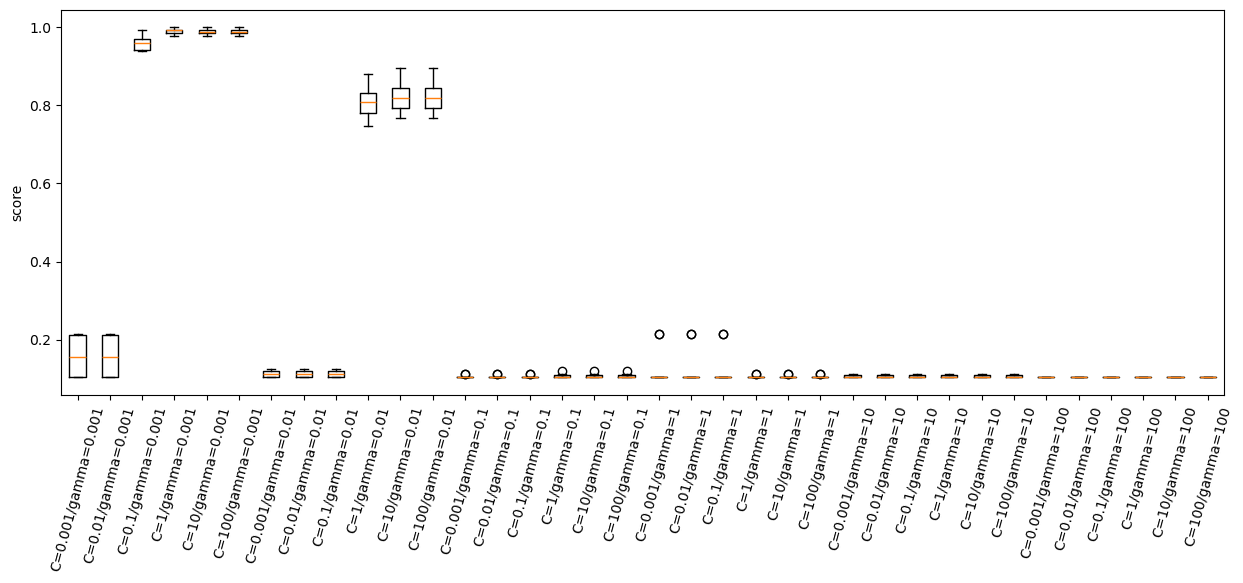

In [11]:
fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(values)
ax.set_xticklabels(labels=labels, rotation=75)
plt.ylabel("score")

plt.show()


## GridSearchCV
Because grid search with cross-validation is such a commonly used method to adjust parameters, scikit-learn provides the GridSearchCV class, which implements it in the form of an estimator. 

(https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [12]:
list_of_params = [.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
        'C': list_of_params, 
        'gamma': list_of_params
    } 

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target, 
                                                    random_state=0)
clf = GridSearchCV(estimator=SVC(), 
                 param_grid=param_grid, 
                 cv=5, 
                 return_train_score=True).fit(X_train, y_train)

print(f'best score: { clf.best_score_}\n best params: {clf.best_params_}\n score over test: {clf.score(X_test, y_test)}\n\n Best estimator: {clf.best_estimator_}')

best score: 0.9918353297535452
 best params: {'C': 10, 'gamma': 0.001}
 score over test: 0.9933333333333333

 Best estimator: SVC(C=10, gamma=0.001)


To see the results we can use the `cv_results_` attribute

In [13]:
clf.cv_results_

{'mean_fit_time': array([0.08516717, 0.07562599, 0.07498193, 0.07699947, 0.07018528,
        0.06979613, 0.07399192, 0.08074007, 0.07749553, 0.07814093,
        0.07628374, 0.07054601, 0.04512277, 0.07537308, 0.07908363,
        0.080407  , 0.07426295, 0.07404809, 0.02763042, 0.08236723,
        0.08301835, 0.08916087, 0.07698612, 0.07783151, 0.02604041,
        0.08458796, 0.08853302, 0.08794637, 0.08819494, 0.08119125,
        0.02694397, 0.0831593 , 0.09807291, 0.09124031, 0.08156481,
        0.08154364]),
 'std_fit_time': array([1.48485782e-02, 4.53527062e-03, 3.24229747e-03, 1.22907626e-03,
        1.33924207e-03, 6.19036684e-04, 1.20979594e-03, 7.82532221e-03,
        2.05433069e-03, 7.60061325e-04, 7.89112420e-03, 3.04506731e-05,
        1.52100560e-04, 1.40849019e-03, 4.26480990e-04, 1.85402578e-04,
        7.46169445e-04, 2.17326370e-04, 3.40713271e-03, 1.19196034e-03,
        1.31367352e-03, 8.92529642e-03, 1.65672465e-03, 5.55942559e-04,
        2.13880341e-04, 2.62271875e-0

Now, we can use `pandas` to have a better look at the results

In [14]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.085167,0.014849,0.026163,0.002407,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
1,0.075626,0.004535,0.024934,0.000283,0.001,0.010,"{'C': 0.001, 'gamma': 0.01}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
2,0.074982,0.003242,0.025251,0.000986,0.001,0.100,"{'C': 0.001, 'gamma': 0.1}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
3,0.076999,0.001229,0.024538,0.000713,0.001,1.000,"{'C': 0.001, 'gamma': 1}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
4,0.070185,0.001339,0.024722,0.001323,0.001,10.000,"{'C': 0.001, 'gamma': 10}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
5,0.069796,0.000619,0.024516,0.000642,0.001,100.000,"{'C': 0.001, 'gamma': 100}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
6,0.073992,0.001210,0.025059,0.000537,0.010,0.001,"{'C': 0.01, 'gamma': 0.001}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
7,0.080740,0.007825,0.027285,0.003876,0.010,0.010,"{'C': 0.01, 'gamma': 0.01}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
8,0.077496,0.002054,0.025302,0.000801,0.010,0.100,"{'C': 0.01, 'gamma': 0.1}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503
9,0.078141,0.000760,0.024156,0.000337,0.010,1.000,"{'C': 0.01, 'gamma': 1}",0.103704,0.103704,0.107807,...,0.106165,0.002010,11,0.106778,0.106778,0.105751,0.105751,0.105751,0.106162,0.000503


In [15]:
results.sort_values(by='mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
24,0.026040,0.000214,0.014532,0.002646,10.0,0.001,"{'C': 10, 'gamma': 0.001}",0.988889,0.992593,0.992565,...,0.991835,0.002775,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
30,0.026944,0.002261,0.013268,0.000280,100.0,0.001,"{'C': 100, 'gamma': 0.001}",0.988889,0.992593,0.992565,...,0.991835,0.002775,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
18,0.027630,0.003407,0.013352,0.000215,1.0,0.001,"{'C': 1, 'gamma': 0.001}",0.992593,0.992593,0.988848,...,0.991089,0.003795,3,0.998143,0.999071,1.000000,0.998145,0.999072,0.998886,0.000695
12,0.045123,0.000152,0.019758,0.000107,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.951852,0.974074,0.955390,...,0.959906,0.008920,4,0.973073,0.973073,0.971243,0.971243,0.969388,0.971604,0.001378
25,0.084588,0.002623,0.024758,0.000125,10.0,0.010,"{'C': 10, 'gamma': 0.01}",0.877778,0.829630,0.847584,...,0.839623,0.031735,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
31,0.083159,0.000939,0.024817,0.000069,100.0,0.010,"{'C': 100, 'gamma': 0.01}",0.877778,0.829630,0.847584,...,0.839623,0.031735,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
19,0.082367,0.001192,0.025022,0.000671,1.0,0.010,"{'C': 1, 'gamma': 0.01}",0.866667,0.822222,0.836431,...,0.826997,0.035562,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
26,0.088533,0.003621,0.024896,0.000297,10.0,0.100,"{'C': 10, 'gamma': 0.1}",0.103704,0.107407,0.107807,...,0.107650,0.002478,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
20,0.083018,0.001314,0.024943,0.000431,1.0,0.100,"{'C': 1, 'gamma': 0.1}",0.103704,0.107407,0.107807,...,0.107650,0.002478,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
32,0.098073,0.020399,0.025099,0.000312,100.0,0.100,"{'C': 100, 'gamma': 0.1}",0.103704,0.107407,0.107807,...,0.107650,0.002478,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


The best parameters are

In [16]:
clf.best_params_

{'C': 10, 'gamma': 0.001}

And now with data never seen

In [17]:
clf = SVC(**clf.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9933333333333333

So, the conclusion is that the model's accuracy is 0.997 % on the test set, showing that the model is quite good.

## Search over spaces that are not grids

In some cases, you may want to search over spaces that are not grids. In this case, we can set the parameter grid as a list of dictionaries, where each dictionary is a point in the parameter space.

In [18]:
param_grid = [
                {
                    'kernel': ['rbf'], 
                    'C': [1, 10, 100],
                    'gamma': [0.001, 0.01, 0.1]
                },
                {
                    'kernel': ['linear'],
                    'C': [0.001, 0.01, 0.1, 1, 10, 100]
                }
            ]

clf = GridSearchCV(
            estimator=SVC(), 
            param_grid=param_grid, 
            cv=5, 
            return_train_score=True).fit(X_train, y_train)

print(f'best score: { clf.best_score_}\n best params: {clf.best_params_}\n score over test: {clf.score(X_test, y_test)}\n\n Best estimator: {clf.best_estimator_}')

best score: 0.9918353297535452
 best params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
 score over test: 0.9933333333333333

 Best estimator: SVC(C=10, gamma=0.001)


## RandomizedSearchCV

The grid search approach is fine when we are exploring relatively few combinations, but when the hyperparameter space is large, it is often preferable to use Randomized Search CV. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter. 

If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used.

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
        'kernel': ['rbf', 'linear'], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1]
    }

clf = RandomizedSearchCV(
            estimator=SVC(), 
            param_distributions=param_dist, 
            n_iter=10,
            cv=5, 
            return_train_score=True).fit(X_train, y_train)

print(f'best score: { clf.best_score_}\n best params: {clf.best_params_}\n score over test: {clf.score(X_test, y_test)}\n\n Best estimator: {clf.best_estimator_}')

best score: 0.9910890816467024
 best params: {'kernel': 'rbf', 'gamma': 0.001, 'C': 1}
 score over test: 0.9955555555555555

 Best estimator: SVC(C=1, gamma=0.001)
